### Save DESI mocks from picca to directSHT format as one big matrix
- [ ] DESI yr-1 mocks `desi-4.124-4-prod` 
    1. picca continuum
    2. true continuum

In [1]:
%matplotlib inline
import numpy as np
import sys,os,fitsio,glob
from astropy.io import fits
import matplotlib.pyplot as plt
import multiprocessing as mp
import re

# define cosmology for comoving distance computation 

# read in DESI yr-5 mocks and save as matrix

In [3]:
LYA_CONST = 1215.67

# eBOSS mocks 
# mock_c='eboss-0.2' # contaminated mocks
mock_version='v9.0'
mock_idx=f'{mock_version}.0'
mock_c='desi-4.0-4'
mock_continuum='true_cont' # true cotninuum
# mock_continuum='baseline' # picca continuum
dir =f"/global/cfs/cdirs/desicollab/science/lya/picca_on_mocks/london/{mock_version}/{mock_idx}/{mock_c}/true_cont/deltas_lya/Delta/"
filelist = np.sort(glob.glob(dir+'delta-*.fits.gz'))

print(len(filelist))
filename = filelist[1]
print(dir+filename)

0


IndexError: index 1 is out of bounds for axis 0 with size 0

In [4]:
def extract_last_integer(input_string):
    # Use regular expression to find all integers in the string
    integers = re.findall(r'\b\d+\b', input_string)
    
    # Check if any integers are found
    if integers:
        # Return the last integer as an integer
        return int(integers[-1])
    else:
        # Return an appropriate value (e.g., None) if no integer is found
        return None

In [5]:
def split_directory_filename(fsave):
    directory = fsave.rsplit('/', 1)[0]
    filename = fsave.rsplit('/', 1)[1]
    return directory, filename


In [6]:
def create_dict_mocks(ra,dec,z_list, targetid,weight_gal, weight_rand, healpix_pix, save_dir, Nx, subsample=False):
    """
    Create a dictionary of mock data and save it to a file.

    Parameters:
    - ra (array-like): Array of right ascension values in radians.
    - dec (array-like): Array of declination values in radians.
    - z_list (array-like): Array of redshift values.
    - targetid (array-like): Array of target ID values.
    - weight_gal (array-like): Array of galaxy weight values: weight*delta
    - weight_rand (array-like): Array of random weight values: weight
    - healpix_pix (array-like): Array of HEALPIX pixel values.
    - save_dir (str): Path to the file where the data will be saved.
    - Nx (int): Number of data points.
    - subsample (bool, optional): Whether to subsample the data. Defaults to False.

    Returns:
    - bool: True if the data is saved successfully, False otherwise.
    """

    data_type=[('redshift', np.float64),\
               ('targetid', np.float64),\
               ('RA',       np.float64),\
               ('DEC',      np.float64),\
               ('w_gal',    np.float64),\
               ('w_rand',   np.float64),\
               ('HEALPIX',  np.float64)]
    dataout=np.zeros(Nx,dtype=data_type)
    
    if subsample:
        print('before subsampling:', ra.size)
        #choose a random subsample from data
        # % of QSOs
        N = np.int32(np.unique(targetid).size/100*10)
        print(N)
        indexes = np.unique(targetid, return_index=True)[1]
        unique_TID = np.array([targetid[index] for index in sorted(indexes)])

        np.random.seed(10)
        random_indices=np.random.choice(unique_TID,N,replace=False)
        mask_subsample=np.in1d(targetid,random_indices)
        ra            = ra[mask_subsample]
        dec           = dec[mask_subsample]
        z_list        = z_list[mask_subsample]
        targetid      = targetid[mask_subsample]
        weight_gal    = weight_gal[mask_subsample]
        weight_rand   = weight_rand[mask_subsample]
        print('after subsampling:', ra.size)
        if ra.size < 100:
            print('do not save this HEALPIX PIXEL')
            return False
        save_dir = save_dir[:-4]+'_sub.npy'
        dataout=np.zeros(ra.size,dtype=data_type)

    dataout['RA']       = ra
    dataout['DEC']      = dec
    dataout['redshift'] = z_list
    dataout['targetid'] = targetid
    dataout['w_gal']    = weight_gal
    dataout['w_rand']   = weight_rand
    dataout['HEALPIX']  = healpix_pix

    if(os.path.isfile(save_dir)):
        print('file exists: STOP \n %s'%(save_dir))
    else:
#        _dir, _name = split_directory_filename(save_dir)
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        print('save \n %s'%(save_dir))
        np.save(save_dir, dataout, allow_pickle=True)


In [7]:
ra = []
dec = []
zpix = []
tid = []
w_gal = []
deltas = []
w_rand = []
c=0
for filename in filelist:
    hdul = fitsio.FITS(filename)
    c_file = hdul['CONT'].read()
    d_file = hdul['DELTA'].read()
    w_file = hdul['WEIGHT'].read()
    lambda_array = hdul['LAMBDA'].read()
    # number of pixels with flux values (not NANs)
    mask_data = np.isfinite(c_file) & np.isfinite(d_file) & np.isfinite(w_file)
    NPIX = mask_data.sum(1)
    NQSO = mask_data.shape[0]
    ra_file  = hdul['METADATA']['RA'].read()
    dec_file = hdul['METADATA']['DEC'].read()
    tid_file = hdul['METADATA']['TARGETID'].read()
    # stack the pixel values 
    ra.append(np.repeat(ra_file, NPIX))
    dec.append(np.repeat(dec_file, NPIX))
    tid.append(np.repeat(tid_file, NPIX))
    for qso_idx in range(NQSO):
        zpix.append(lambda_array[mask_data[qso_idx]]/LYA_CONST - 1.)
        w_gal.append(w_file[qso_idx, mask_data[qso_idx]]*(1.+d_file[qso_idx, mask_data[qso_idx]]))
        deltas.append(d_file[qso_idx, mask_data[qso_idx]])
        w_rand.append(w_file[qso_idx, mask_data[qso_idx]])
    c+=1
    if c%100==0: 
        print(c)
        all_ra    = np.concatenate(ra, axis=0)
        all_dec   = np.concatenate(dec, axis=0)
        all_ra    = np.rad2deg(all_ra)
        all_dec   = np.rad2deg(all_dec)

        all_z     = np.concatenate(zpix, axis=0)
        all_tid   = np.concatenate(tid, axis=0)
        all_w_gal = np.concatenate(w_gal, axis=0)
        all_deltas= np.concatenate(deltas, axis=0)
        all_w_rand= np.concatenate(w_rand, axis=0)
        
        save_name = '/pscratch/sd/r/rmvd2/DESI/mocks/london/{}{}/{}/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no{}.npy'.format(mocks_ver, mocks_name,which_delta,c//100)
        #print(save_name)
        create_dict_mocks(all_ra,
                  all_dec,
                  all_z,
                  all_tid,
                  all_w_gal,
                  all_w_rand, 
                  save_dir=save_name, 
                  Nx=all_ra.size,
                  subsample=True)
        ra = []
        dec = []
        zpix = []
        tid = []
        w_gal = []
        deltas = []
        w_rand = []

KeyboardInterrupt: 

In [ ]:
filename

'/global/cfs/cdirs/desicollab/science/lya/picca_on_mocks/london/v9.0/v9.0.0/desi-4.0-4/true_cont/deltas_lya/Delta/delta-100.fits.gz'

In [39]:
hdul = fitsio.FITS(filename)
c_file = hdul['CONT'].read()
d_file = hdul['DELTA'].read()
w_file = hdul['WEIGHT'].read()


In [18]:
hdul


  file: /global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0_Y1/v9.0.0.0.0/desi-4.124-4-prod//baseline/deltas_lya/Delta/delta-1.fits.gz
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       LAMBDA
  2      BINARY_TBL      METADATA
  3      IMAGE_HDU       DELTA
  4      IMAGE_HDU       WEIGHT
  5      IMAGE_HDU       CONT

In [48]:
hdul['LAMBDA'].read().size

793

In [8]:
hdul


  file: /global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0_Y1/v9.0.0.0.0/desi-4.124-4-prod//baseline/deltas_lya/Delta/delta-1.fits.gz
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       LAMBDA
  2      BINARY_TBL      METADATA
  3      IMAGE_HDU       DELTA
  4      IMAGE_HDU       WEIGHT
  5      IMAGE_HDU       CONT

In [7]:
def save_eBOSSDR16_deltas(filelist, save_name, save_file=False):
    if os.path.isfile(save_name):
        print('file exists: STOP \n %s'%(save_name))
        return 0,0,0,0,0,0,0
    else:
        ra = []
        dec = []
        zpix = []
        tid = []
        w_gal = []
        deltas = []
        w_rand = []
        hp_pix = []
        
        for filename in filelist:
            hdul = fitsio.FITS(filename)
            HEALPIX_PIX = extract_last_integer(filename)
            # print(HEALPIX_PIX)
            
            for hdu in hdul[1:]:
                header = hdu.read_header()
                data = hdu.read()
                Npix = header['NAXIS2']
                assert Npix, (np.isfinite(data['DELTA']) & np.isfinite(data['WEIGHT']) ).sum()
                w_gal.append(data['WEIGHT']*data['DELTA'])
                w_rand.append(data['WEIGHT'])
                ra.append(np.repeat(header['RA'],Npix))
                dec.append(np.repeat(header['DEC'],Npix))
                zpix.append(10.**data['LOGLAM']/LYA_CONST-1)
                tid.append(np.repeat(header['THING_ID'],Npix))
                hp_pix.append(np.repeat(HEALPIX_PIX,Npix))

        all_ra    = np.concatenate(ra, axis=0)
        all_dec   = np.concatenate(dec, axis=0)
        all_ra    = np.rad2deg(all_ra)
        all_dec   = np.rad2deg(all_dec)

        all_z     = np.concatenate(zpix, axis=0)
        all_tid   = np.concatenate(tid, axis=0)
        all_w_gal = np.concatenate(w_gal, axis=0)
        all_w_rand= np.concatenate(w_rand, axis=0)
        all_hp_pix= np.concatenate(hp_pix, axis=0)

        #save_name = '/pscratch/sd/r/rmvd2/DESI/mocks/london/{}{}/{}/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_PIX{}.npy'.format(mocks_ver, mocks_name,which_delta,HEALPIX_PIX)
        #save_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_all_lya_data_RA_DEC_Z_WGAL_WRAND_PIX{}.npy'.format(HEALPIX_PIX)
        #save_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_all_lya_data_RA_DEC_Z_WGAL_WRAND_ALLPIX_FLOAT64.npy'
        # print(save_name)

        if save_file:
                create_dict_mocks(all_ra,
                                all_dec,
                                all_z,
                                all_tid,
                                all_w_gal,
                                all_w_rand, 
                                all_hp_pix,
                                save_dir=save_name, 
                                Nx=all_ra.size,
                                subsample=False)

        return all_ra, all_dec, all_z, all_tid, all_w_gal, all_w_rand, all_hp_pix


In [8]:
fsave='/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_all_lya_data_RA_DEC_Z_WGAL_WRAND_ALLPIX_TEST.npy'
fsave=f"/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/{mock_version}/{mock_c}/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX_test3.npy"
all_ra, all_dec, all_z, all_tid, all_w_gal, all_w_rand, all_hp_pix = save_eBOSSDR16_deltas(filelist[:1], save_name=fsave, save_file=True)

save 
 /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/v9.0.10/eboss-0.0/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX_test3.npy


## run loop on all eBOSS mocks 

In [9]:

def process_mock_batch(idx):
    mock_version=f"v9.0.{idx}"
    dir =f"/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/{mock_version}/{mock_c}/deltas/"
    filelist = np.sort(glob.glob(dir+'delta-*.fits.gz'))
    print(filelist[0]+'\n')

    fsave=f"/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/{mock_version}/{mock_c}/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX.npy"
    all_ra, all_dec, all_z, all_tid, all_w_gal, all_w_rand, all_hp_pix = save_eBOSSDR16_deltas(filelist, save_name=fsave, save_file=True)

# run in series
# for idx in range(1,100):
#    process_mock_batch(idx)


In [10]:
import multiprocessing as mp
# Specify the number of CPUs to be used
num_cpus = 10

# Create a pool of worker processes with the specified number of CPUs
pool = mp.Pool(num_cpus)

# Map the process_mock function to the range of mock versions
pool.map(process_mock_batch, np.arange(0, 100, 1))

# Close the pool to prevent any more tasks from being submitted
pool.close()

# Wait for all worker processes to finish
pool.join()


/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.10/eboss-0.2/deltas/delta-100.fits.gz

/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.31/eboss-0.2/deltas/delta-100.fits.gz

/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.0/eboss-0.2/deltas/delta-100.fits.gz

/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.80/eboss-0.2/deltas/delta-100.fits.gz

/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.37/eboss-0.2/deltas/delta-100.fits.gz
/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.49/eboss-0.2/deltas/delta-100.fits.gz


/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.35/eboss-0.2/deltas/delta-100.fits.gz
/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.2/eboss-0.2/deltas/delta-100.fits.gz


/global/cfs/projectdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.29/eboss-0.2/deltas/delta-100.fit

## read in mocks and convert to xyz

In [ ]:
def convert_coordinates(data, omega_m=0.31, omega_k=0., w_dark_energy=-1.):
    """
    Convert the coordinates from RA, DEC, Z to x, y, z.

    Parameters:
    - data: numpy structured array containing the data with columns 'redshift', 'targetid', 'RA', 'DEC', 'w_gal', 'w_rand', 'HEALPIX'
    - omega_m: float, optional, default=0.31, the matter density parameter
    - omega_k: float, optional, default=0., the curvature density parameter
    - w_dark_energy: float, optional, default=-1., the equation of state parameter for dark energy

    Returns:
    - all_x: numpy array, the x-coordinates in Mpc/h
    - all_y: numpy array, the y-coordinates in Mpc/h
    - all_z: numpy array, the z-coordinates in Mpc/h
    """
    all_redshift = data['redshift']
    all_tid = data['targetid']
    all_ra = data['RA']
    all_dec = data['DEC']
    all_w_gal = data['w_gal']
    all_w_rand = data['w_rand']
    all_healpix = data['HEALPIX']

    # print('convert to x,y,z from RA,DEC')
    from astropy.constants import c as c_light
    import sys
    import astropy.units as u
    sys.path.insert(0, '/global/homes/r/rmvd2/lya_P3D/HIPSTER_20012024/HIPSTER/python/wcdm/')
    import wcdm
    ################### convert to x,y,z #########################
    #print("Converting z to comoving distances:")
    all_comoving_radius = wcdm.coorddist(all_redshift, omega_m, w_dark_energy, omega_k)

    # Convert to Mpc/h
    H_0_h = 100 * u.km / u.s / u.Mpc  # to ensure we get output in Mpc/h units
    H_0_SI = H_0_h.to(1. / u.s)
    comoving_radius_Mpc = ((all_comoving_radius / H_0_SI * c_light).to(u.Mpc)).value

    # Convert to polar coordinates in radians
    all_phi_rad = all_ra * np.pi / 180.
    all_theta_rad = np.pi / 2. - all_dec * np.pi / 180.

    # Now convert to x,y,z coordinates
    all_z = comoving_radius_Mpc * np.cos(all_theta_rad)
    all_x = comoving_radius_Mpc * np.sin(all_theta_rad) * np.cos(all_phi_rad)
    all_y = comoving_radius_Mpc * np.sin(all_theta_rad) * np.sin(all_phi_rad)
    
    return all_x, all_y, all_z, all_w_gal, all_w_rand, all_tid, all_healpix


In [ ]:
def process_mock(mock_version):
    mock_c = 'eboss-0.2' # contaminated mocks
    fin = f"/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/{mock_version}/{mock_c}/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX.npy"
    try:
        data = np.load(fin)
        print(fin+'\n')
        all_x, all_y, all_z, all_w_gal, all_w_rand, all_tid, all_healpix = convert_coordinates(data)

        print('size:', all_x.size)

        select_NGC = True
        if select_NGC:
            # for mocks all_x < 0 --> NGC (for data it is the opposite)
            all_y = all_y[all_x<0]
            all_z = all_z[all_x<0]
            all_w_rand = all_w_rand[all_x<0]
            all_w_gal = all_w_gal[all_x<0]
            all_tid = all_tid[all_x<0]
            all_healpix = all_healpix[all_x<0]
            all_x = all_x[all_x<0]

        print('NGC size: %s \n'%all_x.size)
        fout = f"/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/lya_{mock_version}_{mock_c}_mock_skewers.xyzwrwgth.NGC"

        print("save data \n")
        # Now write to file:
        with open(fout,"w+") as outfile:
            for p in range(all_w_rand.size):
                outfile.write("%.8f %.8f %.8f %.8f %.8f %d %.8f\n" %(all_x[p],
                                                                    all_y[p],
                                                                    all_z[p],
                                                                    all_w_rand[p],
                                                                    (all_w_gal[p]+all_w_rand[p]), # this is w(1+d) !!! 
                                                                    all_tid[p],
                                                                    all_healpix[p]))
        print("Output positions (of length %d) written successfully to %s!"%(all_w_rand.size,fout))
    except:
        print('error for %s \n'%fin)
        pass

In [ ]:
# Specify the number of CPUs to be used
num_cpus = 10

# Create a pool of worker processes with the specified number of CPUs
pool = mp.Pool(num_cpus)

# Map the process_mock function to the range of mock versions
pool.map_async(process_mock, [f"v9.0.{idx}" for idx in range(100)])

# Close the pool to prevent any more tasks from being submitted
pool.close()

# Wait for all worker processes to finish
pool.join()


error for /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/v9.0.1/eboss-0.2/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX.npy 
error for /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/v9.0.4/eboss-0.2/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX.npy 


/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/v9.0.3/eboss-0.2/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX.npy

/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/v9.0.2/eboss-0.2/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX.npy

/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/v9.0.0/eboss-0.2/eBOSS_mock_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_HPX.npy

size: 38897362
size: 38875888
size: 38841660
NGC size: 27515276 

save data 

NGC size: 27509539 

save data 

NGC size: 27467278 

save data 

Output positions (of length 27515276) written successfully to /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/lya_v9.0.2_eboss-0.2_mock_skewers.xyzwrwgth.NGC!
Output positions (of length 27467278) written successfully 

In [81]:
all_x, all_y, all_z, all_w_gal, all_w_rand, all_tid, all_healpix = np.loadtxt('/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/London_mocks/lya_v9.0.0_eboss-0.2_mock_skewers.xyzwrwgth.NGC', unpack=True)

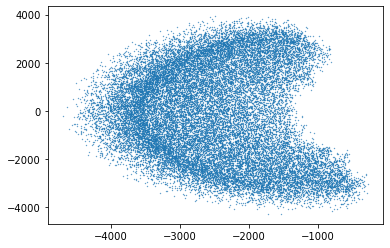

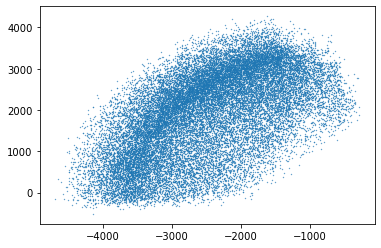

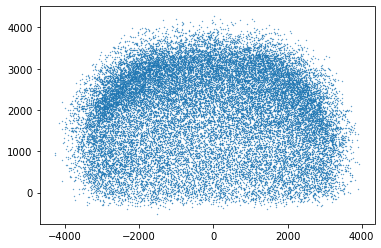

In [82]:
plt.scatter(all_x[::1000], all_y[::1000], s=0.1);plt.show()
plt.scatter(all_x[::1000], all_z[::1000], s=0.1);plt.show()
plt.scatter(all_y[::1000], all_z[::1000], s=0.1);plt.show()

In [83]:
np.unique(all_tid)

array([1.30000000e+01, 3.70000000e+01, 4.10000000e+01, ...,
       3.10272119e+08, 3.10272123e+08, 3.10320055e+08])

In [84]:
all_tid.max()

310320055.0

In [74]:
np.unique(all_tid)

array([1.30000000e+01, 3.70000000e+01, 4.10000000e+01, ...,
       3.10272119e+08, 3.10272123e+08, 3.10320055e+08])

In [78]:
all_tid.max()

310320055.0

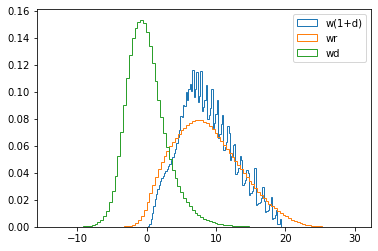

In [71]:
plt.hist(all_w_gal, bins=100, density=True, histtype='step', label='w(1+d)');
plt.hist(all_w_rand, bins=100, density=True, histtype='step', label='wr');
plt.hist(all_w_gal-all_w_rand, bins=100, density=True, histtype='step', label='wd');
plt.legend();plt.show()


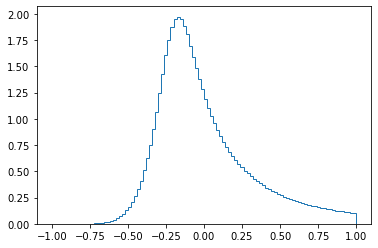

In [69]:
plt.hist(all_w_gal/all_w_rand-1, bins=100, density=True, histtype='step', range=(-1,1),label='d');


In [70]:
(all_w_gal/all_w_rand-1).mean()

0.291811609270692

### comparison old lya file to new file

In [57]:
def read_lya_pixels(file_name):
    print("Counting lines in file {}".format(file_name))
    total_lines=0
    for n, line in enumerate(open(file_name, 'r')):
        total_lines+=1
    print('number of lines {}'.format(total_lines))
    
    X,Y,Z,W,T=[np.zeros(total_lines) for _ in range(5)]

    print("Reading in data");
    for n, line in enumerate(open(file_name, 'r')):
        if n%10000000==0:
            print("Reading line %d of %d" %(n,total_lines))
        split_line=np.array(line.split(" "), dtype=float)
        X[n]=split_line[0];
        Y[n]=split_line[1];
        Z[n]=split_line[2];
        W[n]=split_line[3];
        T[n]=split_line[4];

    N = len(X) # number of particles
    print("Number of random particles %.1e"%N)
    return X,Y,Z,W,T

In [58]:
fname = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_galaxy_new_2023_wd.txt.sub'
#fname = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_galaxy_N14739_skewers_wd.txt.sub'
all_x,all_y,all_z,all_wd_gal,all_tid = read_lya_pixels(fname)

#read in randoms
fname_random = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_new_2023.txt'
#fname_random = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_N14739_skewers.txt.sub'
all_x,all_y,all_z,all_w_rand,all_tid = read_lya_pixels(fname_random)

print("N_gal = %d"%len(all_x))

Counting lines in file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_galaxy_new_2023_wd.txt.sub
number of lines 34318369
Reading in data
Reading line 0 of 34318369
Reading line 10000000 of 34318369
Reading line 20000000 of 34318369
Reading line 30000000 of 34318369
Number of random particles 3.4e+07
Counting lines in file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_new_2023.txt
number of lines 34318369
Reading in data
Reading line 0 of 34318369
Reading line 10000000 of 34318369
Reading line 20000000 of 34318369
Reading line 30000000 of 34318369
Number of random particles 3.4e+07
N_gal = 34318369


In [ ]:
def convert_coordinates(data, omega_m=0.31, omega_k=0., w_dark_energy=-1.):
    """
    Convert the coordinates from RA, DEC, Z to x, y, z.

    Parameters:
    - data: numpy structured array containing the data with columns 'redshift', 'targetid', 'RA', 'DEC', 'w_gal', 'w_rand', 'HEALPIX'
    - omega_m: float, optional, default=0.31, the matter density parameter
    - omega_k: float, optional, default=0., the curvature density parameter
    - w_dark_energy: float, optional, default=-1., the equation of state parameter for dark energy

    Returns:
    - all_x: numpy array, the x-coordinates in Mpc/h
    - all_y: numpy array, the y-coordinates in Mpc/h
    - all_z: numpy array, the z-coordinates in Mpc/h
    """
    all_redshift = data['redshift']
    all_tid = data['targetid']
    all_ra = data['RA']
    all_dec = data['DEC']
    all_w_gal = data['w_gal']
    all_w_rand = data['w_rand']
    all_healpix = data['HEALPIX']

    print('convert to x,y,z from RA,DEC')
    from astropy.constants import c as c_light
    import astropy.units as u
    sys.path.insert(0, '/global/u2/r/rmvd2/HIPSTER_lya/HIPSTER/python/wcdm/')
    import wcdm

    ################### convert to x,y,z #########################
    #print("Converting z to comoving distances:")
    all_comoving_radius = wcdm.coorddist(all_redshift, omega_m, w_dark_energy, omega_k)

    # Convert to Mpc/h
    H_0_h = 100 * u.km / u.s / u.Mpc  # to ensure we get output in Mpc/h units
    H_0_SI = H_0_h.to(1. / u.s)
    comoving_radius_Mpc = ((all_comoving_radius / H_0_SI * c_light).to(u.Mpc)).value

    # Convert to polar coordinates in radians
    all_phi_rad = all_ra * np.pi / 180.
    all_theta_rad = np.pi / 2. - all_dec * np.pi / 180.

    # Now convert to x,y,z coordinates
    all_z = comoving_radius_Mpc * np.cos(all_theta_rad)
    all_x = comoving_radius_Mpc * np.sin(all_theta_rad) * np.cos(all_phi_rad)
    all_y = comoving_radius_Mpc * np.sin(all_theta_rad) * np.sin(all_phi_rad)
    
    return all_x, all_y, all_z, all_w_gal, all_w_rand, all_tid, all_healpix


In [149]:
#data = np.load('/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_all_lya_data_RA_DEC_Z_WGAL_WRAND_ALLPIX_03122023.npy')
data = np.load('/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_all_lya_data_RA_DEC_Z_WGAL_WRAND_ALLPIX_TEST.npy')
all_x1, all_y1, all_z1, all_wd_gal1, all_w_rand1, all_tid1, all_healpix1 = convert_coordinates(data)

convert to x,y,z from RA,DEC


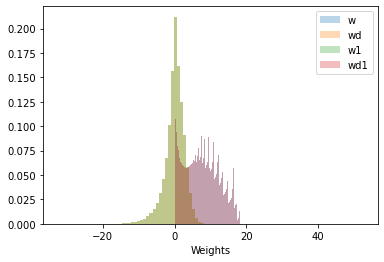

In [132]:
plt.hist(all_w_rand.ravel(),alpha=0.3,density=True,bins=100, label='w')
plt.hist(all_wd_gal.ravel(),alpha=0.3,density=True,bins=100, label='wd')
plt.hist(data['w_gal'].ravel(),alpha=0.3,density=True,bins=100, label='w1')
plt.hist(data['w_rand'].ravel(),alpha=0.3,density=True,bins=100, label='wd1')
plt.xlabel(r'Weights');plt.legend();plt.show()

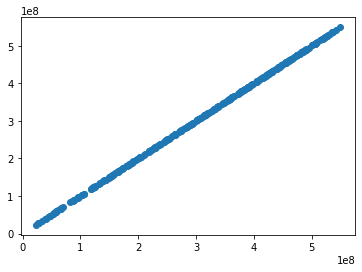

In [162]:
plt.scatter(all_tid[::100000], all_tid1[::100000])

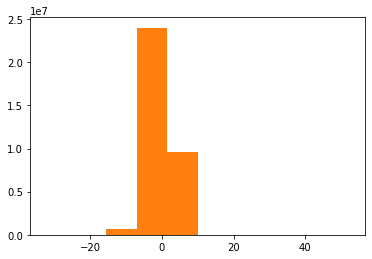

In [155]:
plt.hist(all_w_rand.ravel(),alpha=0.3,density=True,bins=100, label='w')
plt.hist(all_wd_gal.ravel(),alpha=0.3,density=True,bins=100, label='wd'

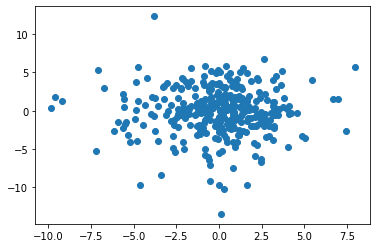

In [157]:
plt.scatter(all_wd_gal[::100000], all_wd_gal1[::100000])

In [120]:
mm = np.in1d(np.unique(data['targetid']), np.unique(all_tid))

((array([12090., 13595., 21619., 20952., 20568., 23255., 26977., 27321.,
         26673., 16955.]),
  array([2.09355720e+07, 7.41658627e+07, 1.27396153e+08, 1.80626444e+08,
         2.33856735e+08, 2.87087026e+08, 3.40317316e+08, 3.93547607e+08,
         4.46777898e+08, 5.00008188e+08, 5.53238479e+08]),
  <BarContainer object of 10 artists>),)

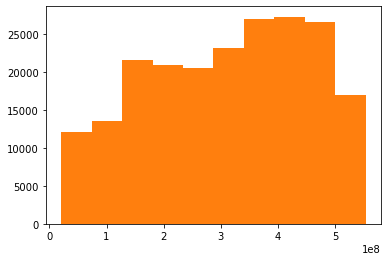

In [121]:
plt.hist(np.unique(data['targetid'])),
plt.hist(np.unique(all_tid)),

In [122]:
dtid_unique = np.unique(data['targetid'])

In [123]:
tid_unique = np.unique(all_tid)

In [124]:
print(dtid_unique.size)
print(tid_unique.size)

210005
210005


In [125]:
tid_unique

array([ 20935572,  20937010,  20953940, ..., 553222739, 553237790,
       553238479])

In [126]:
mm.sum()

210005

In [127]:
np.unique(all_tid).size

210005

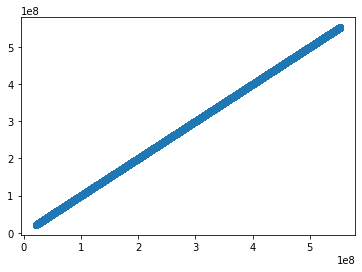

In [130]:
plt.scatter(np.unique(all_tid), np.unique(data['targetid']))

array([4.58396011e+08, 4.58396011e+08, 4.58396011e+08, 4.58396011e+08,
       4.58396011e+08, 4.58396011e+08, 4.58396011e+08, 4.58396011e+08,
       4.58396011e+08, 4.58396011e+08])

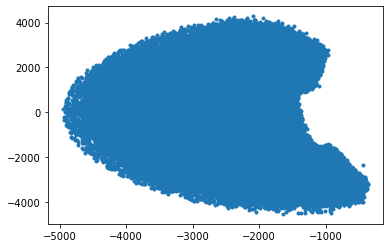

In [12]:
choose_NGC = True
if choose_NGC:
    mask_SGC = all_x<0
    all_x = all_x[mask_SGC]
    all_y = all_y[mask_SGC]
    all_z = all_z[mask_SGC]
    all_w_gal  = all_w_gal[mask_SGC]
    all_w_rand = all_w_rand[mask_SGC]
    all_tid    = all_tid[mask_SGC]
    all_healpix= all_healpix[mask_SGC]
    indexes = np.unique(all_tid, return_index=True)[1]
    unique_mask = [all_x[index] for index in sorted(indexes)]
    plt.scatter([all_x[index] for index in sorted(indexes)],[all_y[index] for index in sorted(indexes)], marker='.');plt.show()

In [13]:
r_max = 220
nrbins=220
nmubins=50

In [15]:
N = len(all_w_gal) # number of particles

print('sum weights gal', np.sum(all_w_gal))
print('sum weights rand', np.sum(all_w_rand))

Nr = len(all_w_rand) # number of particles

# Estimate volume
Vol = (np.max(all_z)-np.min(all_z))*(np.max(all_y)-np.min(all_y))*(np.max(all_x)-np.min(all_x))

print("Number of skewer points %.1e with density %.2e"%(N,N/Vol))

print('Computing pair counts up to a maximum radius of %.2f with %d radial and %d angular bins'%(r_max,nrbins,nmubins))

# Now compute RR counts (with full LoS angles)

binfile = np.linspace(0.,r_max,nrbins+1) # define binning 
binfile[0] += 1e-6 # to eliminate self-counts
r_hi = binfile[1:]
r_lo = binfile[:-1]
r_cen = 0.5*(r_lo+r_hi)
#mu_max = 1. 
mu_max = 0.9999# to avoid self-skewers
print('mu max', mu_max)

r_av = 0.5*(binfile[1:]+binfile[:-1])
# Compute ideal RR counts
RR_th = 4.*np.pi/3.*(binfile[1:]**3-binfile[:-1]**3)*1./nmubins

sum weights gal -28594.791
sum weights rand 187225200.0
Number of skewer points 2.5e+07 with density 1.28e-04
Computing pair counts up to a maximum radius of 220.00 with 220 radial and 50 angular bins
mu max 0.9999


In [17]:
# Compute RR counts for the non-periodic case (measuring mu from the radial direction)
def coord_transform(x,y,z):
    # Convert the X,Y,Z coordinates into Ra,Dec,comoving_distance (for use in corrfunc)
    # Shamelessly stolen from astropy
    xsq = x ** 2.
    ysq = y ** 2.
    zsq = z ** 2.

    com_dist = (xsq + ysq + zsq) ** 0.5
    s = (xsq + ysq) ** 0.5

    if np.isscalar(x) and np.isscalar(y) and np.isscalar(z):
        Ra = math.atan2(y, x)*180./np.pi
        Dec = math.atan2(z, s)*180./np.pi
    else:
        # commented out +180 
        Ra = np.arctan2(y, x)*180./np.pi#+180.
        Dec = np.arctan2(z, s)*180./np.pi
        # # !!! dangerous change!!!!!
        
        #Ra = np.arctan2(y, x)*180./np.pi+180.
        #Dec = np.arctan2(z, s)*180./np.pi
        # !!! dangerous change!!!!!
        Ra = np.mod(Ra-360., 360.)

    return com_dist, Ra, Dec

# Compute Corrfunc counts
def compute_counts(w1,w2, my_ra, my_dec, my_comdist):
    if (w1==w2).all():
        print('auto')
        auto=1
    else:
        auto = 0
        print('cross')
        
    # Run Corrfunc
    XY = DDsmu_mocks(auto,2,nthreads,mu_max,nmubins,binfile,my_ra, my_dec, my_comdist,weights1=w1,weight_type='pair_product',
               RA2=my_ra,DEC2=my_dec,CZ2=my_comdist,weights2=w2,
               is_comoving_dist=True,verbose=True)
    
    # Assemble counts
    XY_counts = (XY[:]['npairs']*XY[:]['weightavg']).reshape((nrbins,nmubins))
    return XY_counts

# Convert coordinates to spherical coordinates
com_dist,Ra,Dec = coord_transform(all_x, all_y, all_z);


In [18]:

def compute_counts_for_pixel(args):
    all_w_rand, all_w_gal, ra, dec, comdist, HP_PIX, outfile, RR_th = args

    RR_counts = compute_counts(all_w_rand, all_w_rand, ra, dec, comdist)
    DD_counts = compute_counts(all_w_gal, all_w_gal, ra, dec, comdist)

    save_matrices_dict = {
        'DD': DD_counts,
        'RR': RR_counts,
        'RR_th': RR_th
    }

    fout = outfile + '%d.npy' % (HP_PIX)
    np.save(fout, save_matrices_dict)
    print("Saved xi(r) computed with Corrfunc from GRF %s" % fout)

def compute_counts_for_pixel_test(args):
    all_w_rand, all_w_gal, ra, dec, comdist, HP_PIX, outfile, RR_th = args
    mask = ~np.in1d(all_healpix, HP_PIX)
    print(mask.sum(), all_healpix.size, HP_PIX)
    fout = outfile + '%d.npy' % (HP_PIX)
    print("Saved xi(r) computed with Corrfunc from GRF %s" % fout)



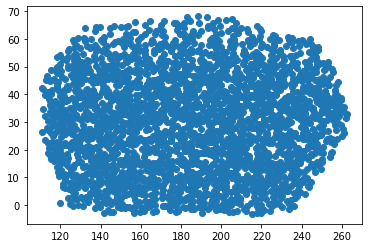

In [19]:
plt.scatter(Ra[::10000],Dec[::10000]);

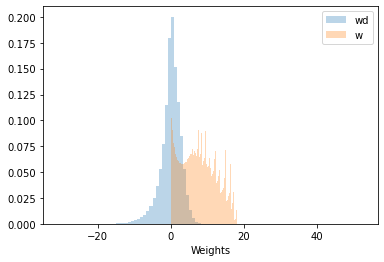

In [41]:
plt.hist(all_w_gal.ravel(),alpha=0.3,density=True,bins=100, label='wd')
plt.hist(all_w_rand.ravel(),alpha=0.3,density=True,bins=100, label='w')
plt.xlabel(r'Weights');plt.legend();plt.show()

In [20]:
# Estimate volume
Vol = (np.max(all_x)-np.min(all_x))*(np.max(all_y)-np.min(all_y))*(np.max(all_z)-np.min(all_z))

print("Number of skewer points %.1e with density %.2e"%(N,N/Vol))

print('Computing pair counts up to a maximum radius of %.2f with %d radial and %d angular bins'%(r_max,nrbins,nmubins))


Number of skewer points 2.5e+07 with density 1.28e-04
Computing pair counts up to a maximum radius of 220.00 with 220 radial and 50 angular bins


In [21]:
# Split the unique_pix into 8 groups for 8 parallel jobs
split_unique_pix = np.array_split(np.unique(all_healpix), 1)

In [22]:
split_unique_pix[0].size

170

In [23]:
nthreads=256

In [85]:
outfile = './data/DD_counts_eBOSSDR16_HEALPIX'
print(outfile)

./data/DD_counts_eBOSSDR16_HEALPIX


In [25]:
for split_pix in split_unique_pix[0][:1]:
    #mask = ~np.in1d(all_healpix, np.int32(split_pix))
    mask = np.in1d(all_healpix, all_healpix)
    print(mask.sum(), all_healpix.size, np.int32(split_pix))
    #job_args_list = [(all_w_rand[mask], all_w_gal[mask], Ra[mask], Dec[mask], com_dist[mask], np.int32(split_pix), outfile, RR_th)]
    RR_counts = compute_counts(all_w_rand[mask], all_w_rand[mask], Ra[mask], Dec[mask], com_dist[mask])
    DD_counts = compute_counts(all_w_gal[mask], all_w_gal[mask], Ra[mask], Dec[mask], com_dist[mask])

    save_matrices_dict = {
        'DD': DD_counts,
        'RR': RR_counts,
        'RR_th': RR_th
    }

    fout = outfile + '%d.npy' % (np.int32(split_pix))
    np.save(fout, save_matrices_dict)
    print("Saved xi(r) computed with Corrfunc from eBOSS DR16 %s" % fout)
    assert(False)
    #compute_counts_for_pixel(job_args_list[0])

24879104 24879104 18
auto


/global/homes/r/rmvd2/.local/lib/python3.9/site-packages/Corrfunc/mocks/DDsmu_mocks.py:364: UserWarning: 
Be aware that small angular pair separations (mu near 1) will suffer from loss
of floating-point precision, as the input data is in float32 precision or
lower. In float32, the loss of precision is 1% in mu at separations of 0.2
degrees, and larger at smaller separations.
For more information, see:
https://github.com/manodeep/Corrfunc/issues/296 (see also #297)

  warnings.warn("""
In gridlink_mocks_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,40,21.  Time taken =   1.252 sec
countpairs_mocks_s_mu_float> gridlink seems inefficient. nmesh = (20, 40, 21); avg_np = 1.48e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,80,21.  Time taken =   1.105 sec
Using AVX kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100

auto


In gridlink_mocks_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,40,21.  Time taken =   0.887 sec
countpairs_mocks_s_mu_float> gridlink seems inefficient. nmesh = (20, 40, 21); avg_np = 1.48e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,80,21.  Time taken =   1.172 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =     2 mins   15 secs


NameError: name 'outfile' is not defined

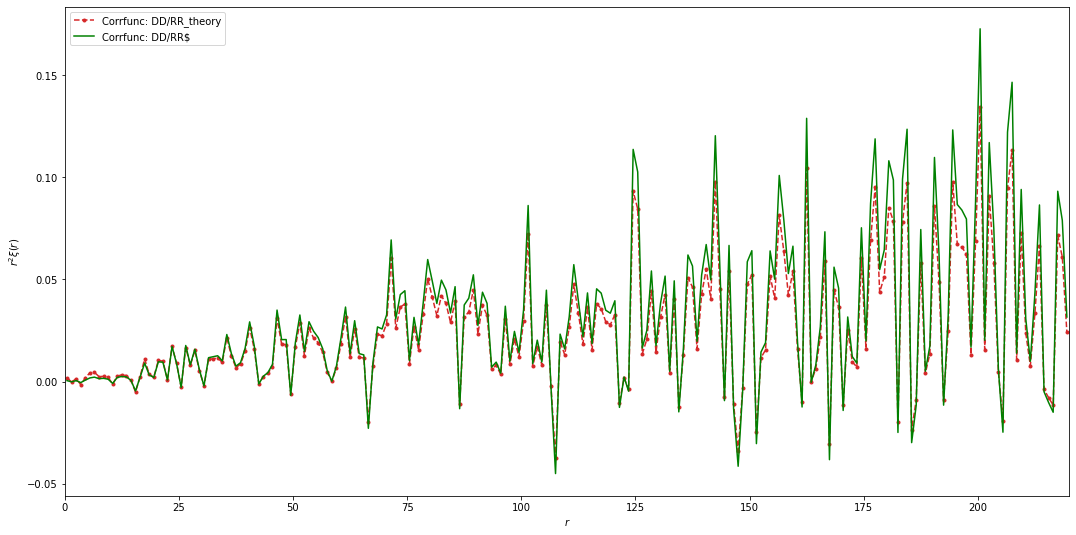

In [54]:
#Phi = RR_counts.mean(axis=1)/RR_th # this is the continuous RR_0(r) function [= Phi] 
xi_cf_ideal = (DD_counts)/RR_th[:,np.newaxis]#*W_r(r_av/R0)[:,np.newaxis]

xi_cf = DD_counts.mean(1)/RR_counts.mean(1)

norm = 1
plt.figure(figsize=(18,9))
plt.plot(r_av,r_av**2*xi_cf_ideal.mean(axis=1)/1300000,'C3.--',label=r'Corrfunc: DD/RR_theory')
plt.plot(r_av,r_av**2*xi_cf,'g-',label=r'Corrfunc: DD/RR$')
plt.legend()
plt.xlim(0,220)
#plt.ylim(-4, 10)
plt.xlabel(r'$r$')
plt.ylabel(r'$r^2\xi(r)$')
plt.show()

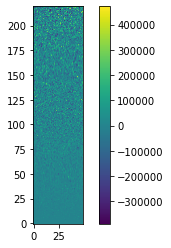

In [31]:
plt.imshow(DD_counts, origin='lower')
plt.colorbar()

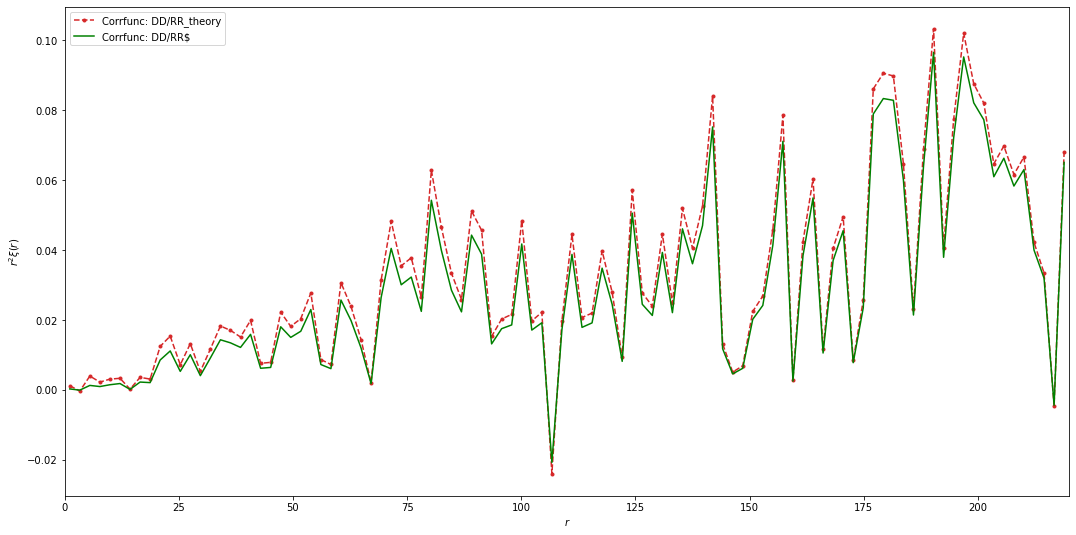

In [31]:
#Phi = RR_counts.mean(axis=1)/RR_th # this is the continuous RR_0(r) function [= Phi] 
xi_cf_ideal = (DD_counts)/RR_th[:,np.newaxis]#*W_r(r_av/R0)[:,np.newaxis]

xi_cf = DD_counts.mean(1)/RR_counts.mean(1)

norm = 1
plt.figure(figsize=(18,9))
plt.plot(r_av,r_av**2*xi_cf_ideal.mean(axis=1)/1300000,'C3.--',label=r'Corrfunc: DD/RR_theory')
plt.plot(r_av,r_av**2*xi_cf,'g-',label=r'Corrfunc: DD/RR$')
plt.legend()
plt.xlim(0,220)
#plt.ylim(-4, 10)
plt.xlabel(r'$r$')
plt.ylabel(r'$r^2\xi(r)$')
plt.show()

In [16]:
ra = []
dec = []
zpix = []
tid = []
w_gal = []
deltas = []
w_rand = []
c=0
for filename in filelist:
    hdul = fitsio.FITS(filename)
    c_file = hdul['CONT'].read()
    d_file = hdul['DELTA'].read()
    w_file = hdul['WEIGHT'].read()
    lambda_array = hdul['LAMBDA'].read()
    # number of pixels with flux values (not NANs)
    mask_data = np.isfinite(c_file) & np.isfinite(d_file) & np.isfinite(w_file)
    NPIX = mask_data.sum(1)
    NQSO = mask_data.shape[0]
    ra_file  = hdul['METADATA']['RA'].read()
    dec_file = hdul['METADATA']['DEC'].read()
    tid_file = hdul['METADATA']['TARGETID'].read()
    # stack the pixel values 
    ra.append(np.repeat(ra_file, NPIX))
    dec.append(np.repeat(dec_file, NPIX))
    tid.append(np.repeat(tid_file, NPIX))
    for qso_idx in range(NQSO):
        zpix.append(lambda_array[mask_data[qso_idx]]/LYA_CONST - 1.)
        w_gal.append(w_file[qso_idx, mask_data[qso_idx]]*(1.+d_file[qso_idx, mask_data[qso_idx]]))
        deltas.append(d_file[qso_idx, mask_data[qso_idx]])
        w_rand.append(w_file[qso_idx, mask_data[qso_idx]])
    c+=1
    if c%100==0: 
        print(c)
        all_ra    = np.concatenate(ra, axis=0)
        all_dec   = np.concatenate(dec, axis=0)
        all_ra    = np.rad2deg(all_ra)
        all_dec   = np.rad2deg(all_dec)

        all_z     = np.concatenate(zpix, axis=0)
        all_tid   = np.concatenate(tid, axis=0)
        all_w_gal = np.concatenate(w_gal, axis=0)
        all_deltas= np.concatenate(deltas, axis=0)
        all_w_rand= np.concatenate(w_rand, axis=0)
        
        save_name = '/pscratch/sd/r/rmvd2/DESI/mocks/london/{}{}/{}/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no{}.npy'.format(mocks_ver, mocks_name,which_delta,c//100)
        #print(save_name)
        create_dict_mocks(all_ra,
                  all_dec,
                  all_z,
                  all_tid,
                  all_w_gal,
                  all_w_rand, 
                  save_dir=save_name, 
                  Nx=all_ra.size,
                  subsample=True)
        ra = []
        dec = []
        zpix = []
        tid = []
        w_gal = []
        deltas = []
        w_rand = []

100
before subsampling: 47823732
4009
after subsampling: 2396121
save 
 /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no1_sub.npy
200
before subsampling: 48412007
4049
after subsampling: 2439742
save 
 /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no2_sub.npy
300
before subsampling: 47085341
3954
after subsampling: 2354239
save 
 /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no3_sub.npy
400
before subsampling: 47409617
3971
after subsampling: 2373724
save 
 /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no4_sub.npy
500
before subsampling: 45200856
3797
after subsampling: 2270212
save 
 /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks

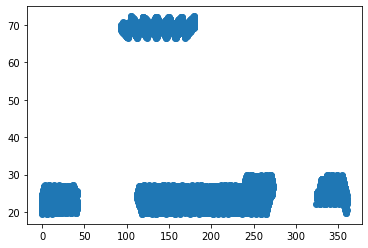

In [17]:
plt.scatter(all_ra[::1000], all_dec[::1000])

In [30]:
all_z.shape

(554827180,)

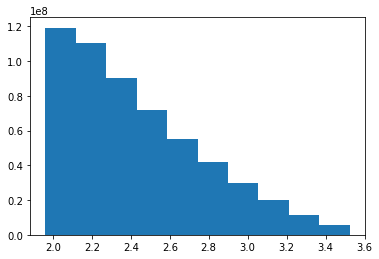

In [31]:
plt.hist(all_z);

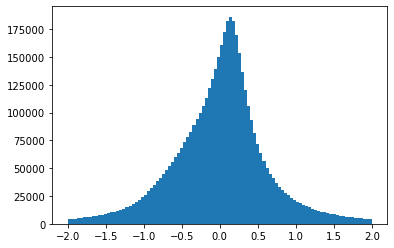

In [19]:
plt.hist(all_deltas, bins=100, range=(-2, 2));

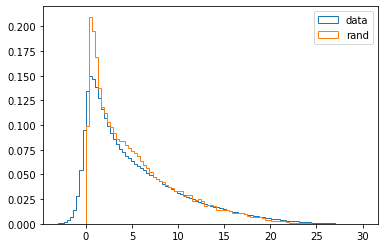

In [23]:
plt.hist(all_w_gal, bins=100, range=(-3, 30), density=True, histtype='step', label='data');
plt.hist(all_w_rand, bins=100, range=(-3, 30), density=True, histtype='step', label='rand');
plt.legend()

In [36]:
#save_name = '/global/cscratch1/sd/rmvd2/eBOSS_DR16/lya/data/eBOSS_DR16_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND.npy'
save_name = '/pscratch/sd/r/rmvd2/DESI/mocks/london/{}{}/{}/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND.npy'.format(mocks_ver, mocks_name,which_delta)
print(save_name)

/pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/deltas_lya/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND.npy


In [ ]:
create_dict_mocks(all_ra,
                  all_dec,
                  all_z,
                  all_tid,
                  all_w_gal,
                  all_w_rand, 
                  save_dir=save_name, 
                  Nx=all_ra.size,
                  subsample=True)

before subsampling: 554827180


In [ ]:
data = np.load(save_name)

In [ ]:
create_dict_mocks(data['RA'],
                  data['DEC'],
                  data['redshift'],
                  data['targetid'],
                  data['w_gal'],
                  data['w_rand'], 
                  save_dir=save_name, 
                  Nx=data['RA'].size,
                  subsample=True)

In [ ]:
data['redshift'].size

In [ ]:
plt.hist(data['redshift'], bins=100, density=True);
#plt.hist(all_z, bins=100, density=True);

In [ ]:
plt.hist(data['w_gal'],histtype='step', density=True, bins=100,  label='data');
plt.hist(1+data['w_rand'],histtype='step', density=True, bins=100,  label='1+rand');
#plt.hist(1.+all_deltas,histtype='step', density=True,  bins=100, range=(-3,3),label='1+delta');
#plt.hist(all_w_rand*(1.+all_deltas),histtype='step', density=True,  bins=100,  label='w(1+delta)');
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel('normalised hist');

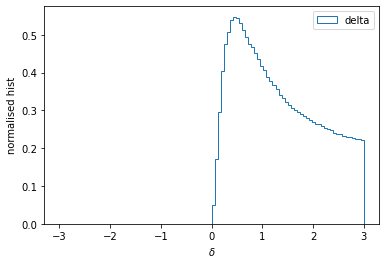

In [10]:
plt.hist(all_deltas,histtype='step', density=True, bins=100,range=(-3,3),  label='delta');
#plt.hist(1.+all_deltas,histtype='step', density=True,  bins=100, range=(-3,3),label='1+delta');
#plt.hist(all_w_rand*(1.+all_deltas),histtype='step', density=True,  bins=100,  label='w(1+delta)');
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel('normalised hist');

In [40]:
#plt.hist(all_w_rand*(1.+all_deltas/5),histtype='step', density=True,  bins=100,  label='w(1+delta) greater zero');
plt.hist(all_w_rand,histtype='step', density=True,  bins=100,  label='w rand');
plt.hist(all_w_gal,histtype='step', density=True,  bins=100,  label='w(1+delta)');
plt.legend()
plt.xlim(-5, 30)
plt.ylabel('normalised hist');

NameError: name 'all_w_rand' is not defined

In [41]:
print(np.median(all_deltas))
print(np.mean(all_deltas))

NameError: name 'all_deltas' is not defined

In [70]:
from astropy.constants import c as c_light
import astropy.units as u
sys.path.insert(0, '/global/u2/r/rmvd2/HIPSTER_lya/HIPSTER/python/wcdm/')
import wcdm

omega_m = 0.31
omega_k = 0.
w_dark_energy = -1.

In [73]:
subsample=True
if subsample:
    sub = '_sub'
else:
    sub = ''
    
for filename in filelist:
    try:
        HEALPIX_PIX = extract_last_integer(filename)
        save_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_all_lya_data_RA_DEC_Z_WGAL_WRAND_PIX{}{}.npy'.format(HEALPIX_PIX,sub)
        data_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_data_RA_DEC_Z_WGAL_PIX{}{}.npy'.format(HEALPIX_PIX,sub)
        rand_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX{}{}.npy'.format(HEALPIX_PIX,sub)
        #print(save_name)
        data         = np.load(save_name)
        all_redshift = data['redshift']
        all_tid      = data['targetid']
        all_ra       = data['RA']
        all_dec      = data['DEC']
        all_w_gal    = data['w_gal']
        all_w_rand   = data['w_rand']

        ################### data #########################
        #print("Converting z to comoving distances:")
        all_comoving_radius=wcdm.coorddist(all_redshift,omega_m,w_dark_energy,omega_k)

        # Convert to Mpc/h
        H_0_h=100*u.km/u.s/u.Mpc # to ensure we get output in Mpc/h units
        H_0_SI = H_0_h.to(1./u.s)
        comoving_radius_Mpc = ((all_comoving_radius/H_0_SI*c_light).to(u.Mpc)).value

        # Convert to polar coordinates in radians
        all_phi_rad = all_ra*np.pi/180.
        all_theta_rad = np.pi/2.-all_dec*np.pi/180.

        # Now convert to x,y,z coordinates
        all_z = comoving_radius_Mpc*np.cos(all_theta_rad)
        all_x = comoving_radius_Mpc*np.sin(all_theta_rad)*np.cos(all_phi_rad)
        all_y = comoving_radius_Mpc*np.sin(all_theta_rad)*np.sin(all_phi_rad)

        #print("Writing to file %s:"%rand_name)
        # Now write to file:
        with open(rand_name,"w+") as outfile:
            for p in range(all_w_rand.size):
                outfile.write("%.8f %.8f %.8f %.8f %.8f\n" %(all_x[p],
                                                             all_y[p],
                                                             all_z[p],
                                                             all_w_rand[p],
                                                             all_tid[p]))
        #print("Output positions (of length %d) written succesfully!"%all_w_rand.size)

        #print("Writing to file %s:"%data_name)
        # Now write to file:
        with open(data_name,"w+") as outfile:
            for p in range(all_w_gal.size):
                outfile.write("%.8f %.8f %.8f %.8f %.8f\n" %(all_x[p],
                                                             all_y[p],
                                                             all_z[p],
                                                             all_w_gal[p],
                                                             all_tid[p]))
        #print("Output positions (of length %d) written succesfully!"%all_w_gal.size)
    except:
        print("PROBLEM: Writing to file %s:"%rand_name)

PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX112_sub.npy:
PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX143_sub.npy:
PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX179_sub.npy:
PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX29_sub.npy:
PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX307_sub.npy:
PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX341_sub.npy:
PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX372_sub.npy:
PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX411_sub.npy:
PROBLEM: Writing to file /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/eBOSS_DR16_lya_rand_RA_DEC_Z_WRAND_PIX54_sub

In [28]:
subsample=False
if subsample:
    sub = '_sub'
else:
    sub = ''
    
for i in range(1,13):
    save_name = '/pscratch/sd/r/rmvd2/DESI/mocks/london/{}{}/{}/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no{}{}.npy'.format(mocks_ver, mocks_name,which_delta,i,sub)
    data_name = '/pscratch/sd/r/rmvd2/DESI/mocks/london/{}{}/{}/DESI_mocks_all_lya_data_no{}{}.xyzw'.format(mocks_ver, mocks_name,which_delta,i,sub)
    rand_name = '/pscratch/sd/r/rmvd2/DESI/mocks/london/{}{}/{}/DESI_mocks_all_lya_rand_no{}{}.xyzw'.format(mocks_ver, mocks_name,which_delta,i,sub)
    print(save_name)
    data         = np.load(save_name)
    all_redshift = data['redshift']
    all_tid      = data['targetid']
    all_ra       = data['RA']
    all_dec      = data['DEC']
    all_w_gal    = data['w_gal']
    all_w_rand   = data['w_rand']

    ################### data #########################
    print("Converting z to comoving distances:")
    all_comoving_radius=wcdm.coorddist(all_redshift,omega_m,w_dark_energy,omega_k)

    # Convert to Mpc/h
    H_0_h=100*u.km/u.s/u.Mpc # to ensure we get output in Mpc/h units
    H_0_SI = H_0_h.to(1./u.s)
    comoving_radius_Mpc = ((all_comoving_radius/H_0_SI*c_light).to(u.Mpc)).value

    # Convert to polar coordinates in radians
    all_phi_rad = all_ra*np.pi/180.
    all_theta_rad = np.pi/2.-all_dec*np.pi/180.

    # Now convert to x,y,z coordinates
    all_z = comoving_radius_Mpc*np.cos(all_theta_rad)
    all_x = comoving_radius_Mpc*np.sin(all_theta_rad)*np.cos(all_phi_rad)
    all_y = comoving_radius_Mpc*np.sin(all_theta_rad)*np.sin(all_phi_rad)
    
    print("Writing to file %s:"%rand_name)
    # Now write to file:
    with open(rand_name,"w+") as outfile:
        for p in range(all_w_rand.size):
            outfile.write("%.8f %.8f %.8f %.8f %.8f\n" %(all_x[p],
                                                         all_y[p],
                                                         all_z[p],
                                                         all_w_rand[p],
                                                         all_tid[p]))
    print("Output positions (of length %d) written succesfully!"%all_w_rand.size)

    print("Writing to file %s:"%data_name)
    # Now write to file:
    with open(data_name,"w+") as outfile:
        for p in range(all_w_gal.size):
            outfile.write("%.8f %.8f %.8f %.8f %.8f\n" %(all_x[p],
                                                         all_y[p],
                                                         all_z[p],
                                                         all_w_gal[p],
                                                         all_tid[p]))
    print("Output positions (of length %d) written succesfully!"%all_w_gal.size)

/pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no1.npy
Converting z to comoving distances:
Writing to file /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_rand_no1.xyzw:
Output positions (of length 47823732) written succesfully!
Writing to file /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_data_no1.xyzw:
Output positions (of length 47823732) written succesfully!
/pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_data_RA_DEC_Z_TID_WGAL_WRAND_no2.npy
Converting z to comoving distances:
Writing to file /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_mocks_all_lya_rand_no2.xyzw:
Output positions (of length 48412007) written succesfully!
Writing to file /pscratch/sd/r/rmvd2/DESI/mocks/london/v9.0/v9.0.0/desi-3.0-4/true_deltas_lya/DESI_

In [29]:
3

3

### plot X,Y coordinates --> check units

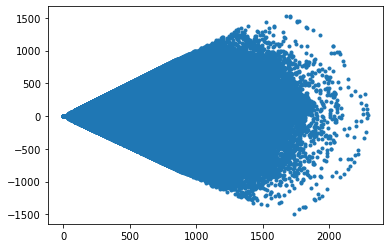

In [8]:
fname_data = '/pscratch/sd/r/rmvd2/BOSS_DR12/data/random0_DR12v5_LOWZ_South_xyzw.txt'
Xold,Yold = np.loadtxt(fname_data, usecols=(0,1), unpack=True)
plt.scatter(Xold,Yold, marker='.')

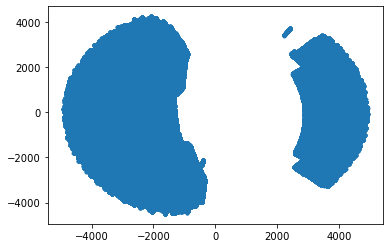

In [168]:
N=2000
fname_data = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_galaxy_N{}_skewers.txt.sub'.format(N)
#fname_data ='/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_galaxy_degree.txt'
Xgal,Ygal,Zgal,Wgal, Tgal = np.loadtxt(fname_data, unpack=True)
#plt.scatter(Xgal,Ygal, marker='.')

In [4]:
fname_data ='/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_galaxy_degree.txt'
Xgal,Ygal,Zgal,Wgal, Tgal = np.loadtxt(fname_data, unpack=True)


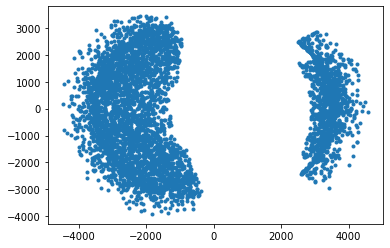

In [144]:
#only plot 1 pix per QSO not entire forest
indexes = np.unique(Tgal, return_index=True)[1]
unique_mask = [Xgal[index] for index in sorted(indexes)]
plt.scatter([Xgal[index] for index in sorted(indexes)],[Ygal[index] for index in sorted(indexes)], marker='.')

In [93]:
fname_data = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_N{}_skewers.txt.sub'.format(N)
#fname_data ='/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_degree.txt'
X,Y,Z,W,T = np.loadtxt(fname_data, unpack=True)
#plt.scatter(X,Y, marker='.')


In [3]:
fname_data ='/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_degree.txt'
X,Y,Z,W,T = np.loadtxt(fname_data, unpack=True)


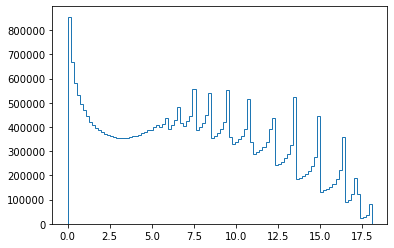

In [4]:
plt.hist(W,histtype='step', bins=100, label='random: w');

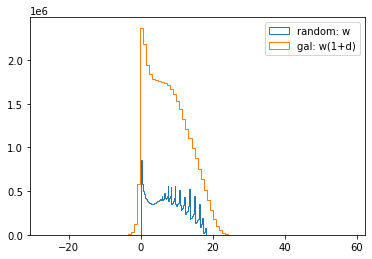

In [6]:
#weights for randoms, ie. the Lya pixels are weighted by w_i = w_i
plt.hist(W,histtype='step', bins=100, label='random: w');
plt.hist(Wgal,histtype='step', bins=100, label='gal: w(1+d)');plt.legend();

### choose only skewers from 'SGC'

In [5]:

mask_SGC = X<0
X = X[mask_SGC]
Y = Y[mask_SGC]
Z = Z[mask_SGC]
W = W[mask_SGC]
T = T[mask_SGC]
#plt.scatter(X, Y)

In [ ]:
# choose subsample of only 'left' skewers, similar to NGC/SGC for galaxies
mask_SGC = Xgal<0
Xgal = Xgal[mask_SGC]
Ygal = Ygal[mask_SGC]
Zgal = Zgal[mask_SGC]
Wgal = Wgal[mask_SGC]
Tgal = Tgal[mask_SGC]
#plt.scatter(Xgal, Ygal)

mask_SGC = X<0
X = X[mask_SGC]
Y = Y[mask_SGC]
Z = Z[mask_SGC]
W = W[mask_SGC]
T = T[mask_SGC]
#plt.scatter(X, Y)

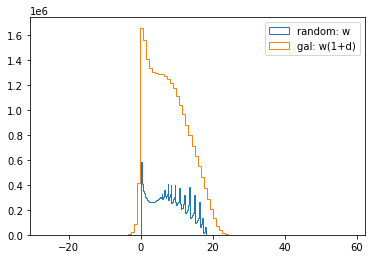

In [6]:
#weights for randoms, ie. the Lya pixels are weighted by w_i = w_i
plt.hist(W,histtype='step', bins=100, label='random: w');
plt.hist(Wgal,histtype='step', bins=100, label='gal: w(1+d)');plt.legend();

### start computing correction function

In [6]:
#total_lines = all_tid.size
NPIX=len(X)
total_lines = NPIX

In [7]:
# for 2000 skewers 326411 pixel
# only 'SGC':      235804 pixel

In [8]:
#X,Y,Z,W,T=[np.zeros(total_lines) for _ in range(5)]

In [74]:
'''
def coord_transform(x,y,z):
    # Convert the X,Y,Z coordinates into Ra,Dec,comoving_distance (for use in corrfunc)
    # Shamelessly stolen from astropy
    xsq = x ** 2.
    ysq = y ** 2.
    zsq = z ** 2.

    com_dist = (xsq + ysq + zsq) ** 0.5
    s = (xsq + ysq) ** 0.5

    if np.isscalar(x) and np.isscalar(y) and np.isscalar(z):
        Ra = math.atan2(y, x)*180./np.pi
        Dec = math.atan2(z, s)*180./np.pi
    else:
        Ra = np.arctan2(y, x)*180./np.pi+180.
        Dec = np.arctan2(z, s)*180./np.pi

    return com_dist, Ra, Dec

# Convert the X,Y,Z coordinates into Ra,Dec,comoving_distance (for use in corrfunc)
# Shamelessly stolen from astropy
'''
def coord_transform(x,y,z):
    xsq = x ** 2.
    ysq = y ** 2.
    zsq = z ** 2.

    com_dist = (xsq + ysq + zsq) ** 0.5
    s = (xsq + ysq) ** 0.5

    if np.isscalar(x) and np.isscalar(y) and np.isscalar(z):
        Ra = math.atan2(y, x)*180./np.pi
        Dec = math.atan2(z, s)*180./np.pi
    else:
        # commented out +180 
        Ra = np.arctan2(y, x)*180./np.pi#+180.
        Dec = np.arctan2(z, s)*180./np.pi
        # !!! dangerous change!!!!!
        Ra = np.mod(Ra-360., 360.)
        
    return com_dist, Ra, Dec


In [10]:
r_max = 100
nrbins = 20
nmu_bins = 10
nthreads = 10
#mu_max = 1.
mu_max = 0.9900
print('mu max', mu_max)

mu max 0.99


In [11]:
N = len(X) # number of particles

print("Number of random particles %.1e"%N)

print('Computing pair counts up to a maximum radius of %.2f'%r_max)

binfile = np.linspace(0,r_max,nrbins+1)
binfile[0]=1e-2 # to avoid zero errors
r_hi = binfile[1:]
r_lo = binfile[:-1]
r_cen = 0.5*(r_lo+r_hi)


Number of random particles 2.5e+07
Computing pair counts up to a maximum radius of 100.00


In [12]:
'''
print("Reading in data");
for n, line in enumerate(open(fname_data, 'r')):
    if n%1000000==0:
        print("Reading line %d of %d" %(n,total_lines))
    split_line=np.array(line.split(" "), dtype=float)
    X[n]=split_line[0];
    Y[n]=split_line[1];
    Z[n]=split_line[2];
    W[n]=split_line[3];
    T[n]=split_line[4];
'''

'\nprint("Reading in data");\nfor n, line in enumerate(open(fname_data, \'r\')):\n    if n%1000000==0:\n        print("Reading line %d of %d" %(n,total_lines))\n    split_line=np.array(line.split(" "), dtype=float)\n    X[n]=split_line[0];\n    Y[n]=split_line[1];\n    Z[n]=split_line[2];\n    W[n]=split_line[3];\n    T[n]=split_line[4];\n'

In [13]:
com_dist,Ra,Dec = coord_transform(X,Y,Z);

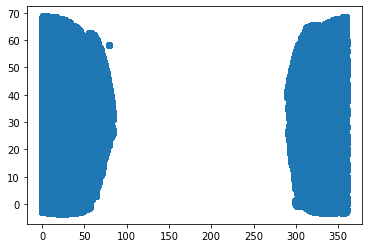

In [72]:
plt.scatter(Ra,Dec)

In [14]:
indexes = np.unique(T, return_index=True)[1]
unique_TID = np.array([T[index] for index in sorted(indexes)])

In [15]:
T.size

24879104

In [16]:
unique_TID.size

151413

In [17]:
'''
plt.plot(T)
plt.show()

random_indices=np.random.choice(unique_TID,100,replace=False)
mask_subsample=np.in1d(T,random_indices)
TT = T[mask_subsample]
plt.plot(TT)
#mask_subsample=np.in1d(T,unique_TID[500:600])
#TT = T[mask_subsample]
#plt.plot(TT)
'''

'\nplt.plot(T)\nplt.show()\nrandom_indices=np.random.choice(unique_TID,100,replace=False)\nmask_subsample=np.in1d(T,random_indices)\nTT = T[mask_subsample]\nplt.plot(TT)\n#mask_subsample=np.in1d(T,unique_TID[500:600])\n#TT = T[mask_subsample]\n#plt.plot(TT)\n'

In [18]:
print('Computing unweighted RR pair counts')

RR=DDsmu_mocks(1,2,mp.cpu_count()-1,
#RR=DDsmu_mocks(1,2,nthreads,
               mu_max,nmu_bins,binfile,
               Ra,Dec,com_dist,weights1=W,
               weight_type='pair_product',
               verbose=False,
               is_comoving_dist=True)
# Weight by average particle weighting
RR_counts=(RR[:]['npairs']*RR[:]['weightavg']).reshape((nrbins,nmu_bins))

Computing unweighted RR pair counts


In [19]:
print('old ', RR_counts)

old  [[2.54973052e+08 0.00000000e+00 0.00000000e+00 6.88308870e+06
  1.74278080e+08 1.00535060e+08 6.02019074e+07 4.87661281e+07
  1.18897379e+08 8.50683415e+07]
 [7.12230670e+08 2.51265998e+07 9.88783897e+08 4.00607965e+08
  6.27262080e+08 3.97925118e+08 6.69004309e+08 5.09600564e+08
  6.01682309e+08 5.00837760e+08]
 [1.16519859e+09 2.23822136e+09 8.57709648e+08 1.44693836e+09
  1.40510595e+09 1.55680577e+09 1.22171196e+09 1.45550178e+09
  1.42503409e+09 1.59910579e+09]
 [1.69056833e+09 3.13522656e+09 3.08784162e+09 2.96125185e+09
  2.56722232e+09 2.69359010e+09 2.81044448e+09 2.75568712e+09
  2.66990352e+09 2.85827225e+09]
 [5.80882263e+09 3.92491084e+09 3.90663288e+09 4.01806816e+09
  4.41553031e+09 4.45764390e+09 4.31865350e+09 4.36079943e+09
  4.43240190e+09 4.66213570e+09]
 [7.30775655e+09 4.97501848e+09 7.54557289e+09 6.26840645e+09
  6.59964959e+09 6.17553444e+09 6.59519836e+09 6.52663061e+09
  6.68867858e+09 6.75814144e+09]
 [8.65226048e+09 1.07867539e+10 7.66769299e+09 9.3064

In [20]:
RR_counts.shape

(20, 10)

In [21]:
RR[:]['npairs'].sum()

91618010444

In [22]:
RR_counts.sum()

5511547519179.844

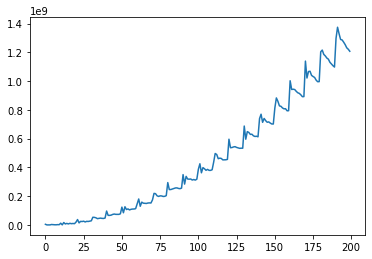

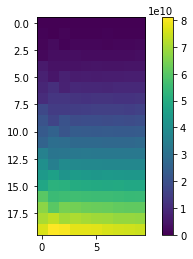

In [23]:
#20x10
plt.plot(RR[:]['npairs'])
plt.show()
plt.imshow(RR_counts)
plt.colorbar()

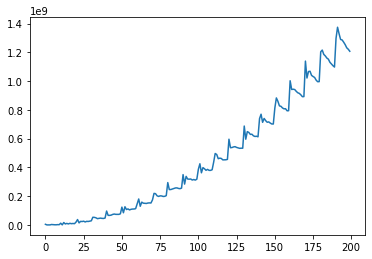

In [24]:
#10x10
plt.plot(RR[:]['npairs'])

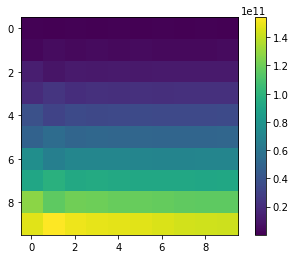

In [58]:
#10x10
plt.imshow(RR_counts)
plt.colorbar()

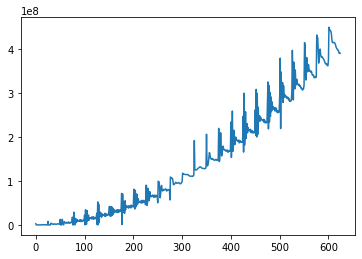

In [37]:
# 25x25
plt.plot(RR[:]['npairs'])

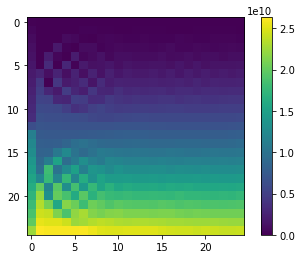

In [29]:
plt.imshow(RR_counts)
plt.colorbar()

In [28]:
RR_npairs_auto=np.zeros(nmu_bins*(binfile.size-1))
print(RR_npairs_auto.shape)
print('T shape', T.shape)
# keep old sorting 
indexes = np.unique(T, return_index=True)[1]
unique_TID = np.array([T[index] for index in sorted(indexes)])
print('unique T shape', unique_TID.shape)
#print(X.shape)
#print(Y.shape)
#print(Z.shape)
#print(W.shape)
#print(T.shape)

# sum of weights per skewer and THEN squared
counter=0
print('counter')
# RR only auto-correlation of the skewers
for skewer_idx in range(unique_TID.size):
    mask_skewer = np.in1d(T,unique_TID[skewer_idx],assume_unique=False)
    if mask_skewer.sum() == 0:
        continue
    counter   += mask_skewer.sum()
    RR_auto = DDsmu_mocks(1,2,nthreads,mu_max,nmu_bins,binfile,Ra[mask_skewer],Dec[mask_skewer],com_dist[mask_skewer],weights1=W[mask_skewer],weight_type='pair_product',verbose=False,is_comoving_dist=True)
    RR_npairs_auto += (RR_auto[:]['npairs']*RR_auto[:]['weightavg'])#/(np.sum(W[mask_skewer])**2)


(625,)
T shape (24879104,)
unique T shape (151413,)
counter


KeyboardInterrupt: 

In [63]:

# Weight by average particle weighting
RR_counts_auto=(RR_npairs_auto).reshape((nrbins,nmu_bins))
print('number of auto skewers:{}'.format(counter))
print(RR_counts_auto)
print('compute: RR_all_pairs - RR_auto_pairs')
# new normailsation check in cell RR_count/RR_model
RR_counts = RR_counts-RR_counts_auto # norm should be ok (double check - rmvd2!!!!!!!!!!!)
#/(np.sum(W)**2)
print('new', RR_counts)

ValueError: cannot reshape array of size 625 into shape (10,10)

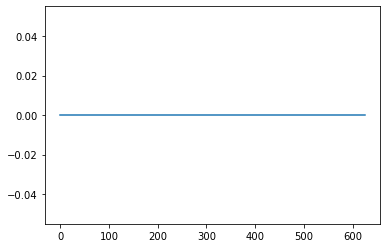

In [64]:
plt.plot(RR_npairs_auto)

In [ ]:
plt.imshow(RR_counts_auto)

In [ ]:
counter

In [ ]:
unique_TID.size

In [32]:
norm = np.sum(W)**2. # partial normalization - divided by np.sum(W_gal)**2 in reconstruction script
print("Old normalisation DD = %.2f"%norm)

Old normalisation DD = 35053285871978856.00


In [36]:
RR_counts

array([[2.54973052e+08, 0.00000000e+00, 0.00000000e+00, 6.88308870e+06,
        1.74278080e+08, 1.00535060e+08, 6.02019074e+07, 4.87661281e+07,
        1.18897379e+08, 8.50683415e+07],
       [7.12230670e+08, 2.51265998e+07, 9.88783897e+08, 4.00607965e+08,
        6.27262080e+08, 3.97925118e+08, 6.69004309e+08, 5.09600564e+08,
        6.01682309e+08, 5.00837760e+08],
       [1.16519859e+09, 2.23822136e+09, 8.57709648e+08, 1.44693836e+09,
        1.40510595e+09, 1.55680577e+09, 1.22171196e+09, 1.45550178e+09,
        1.42503409e+09, 1.59910579e+09],
       [1.69056833e+09, 3.13522656e+09, 3.08784162e+09, 2.96125185e+09,
        2.56722232e+09, 2.69359010e+09, 2.81044448e+09, 2.75568712e+09,
        2.66990352e+09, 2.85827225e+09],
       [5.80882263e+09, 3.92491084e+09, 3.90663288e+09, 4.01806816e+09,
        4.41553031e+09, 4.45764390e+09, 4.31865350e+09, 4.36079943e+09,
        4.43240190e+09, 4.66213570e+09],
       [7.30775655e+09, 4.97501848e+09, 7.54557289e+09, 6.26840645e+09,
   

Compute correction function model


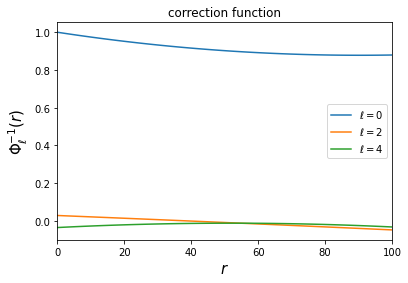

In [33]:

# Now compute ideal model for RR Counts
print("Compute correction function model")
mu_cen = np.arange(1/(2*nmu_bins),1.+1/(2*nmu_bins),1/nmu_bins)
delta_mu = (mu_cen[-1]-mu_cen[-2])
delta_mu_all = delta_mu*np.ones_like(mu_cen).reshape(1,-1)
# removed '*norm' for individual normalisation of RR_counts = RR_counts/(np.sum(W)**2)-RR_counts_auto
# RR_counts_auto is normalised on a per skewer basis '/(np.sum(W[mask_skewer])**2)'
RR_model = 4.*np.pi*(r_hi**3.-r_lo**3.).reshape(-1,1)*delta_mu_all*norm/3. 

# Compute inverse Phi function and multipoles
inv_phi = RR_counts/RR_model
l_max = 4
from scipy.special import legendre
inv_Phi_multipoles = np.zeros([l_max//2+1,len(inv_phi)])
for i in range(len(RR_counts)):
    for l_i,ell in enumerate(np.arange(0,l_max+2,2)):
        inv_Phi_multipoles[l_i,i]=(2.*ell+1.)*delta_mu*np.sum(legendre(ell)(mu_cen)*inv_phi[i,:])

# Now fit to a smooth model
def inv_phi_ell_model(r,*par):
    return par[0]+par[1]*r+par[2]*r**2.
from scipy.optimize import curve_fit
all_ell = np.arange(0,l_max+2,2)
corr_func = np.asarray([curve_fit(inv_phi_ell_model,r_cen[1:],inv_Phi_multipoles[ell//2][1:],
                              p0=[0 for _ in range(3)])[0] for ell in all_ell])


C_r = lambda r: inv_phi_ell_model(r,*corr_func.T)

rs = np.arange(r_max+1)
for li in range(3):
    plt.plot(rs,[C_r(r)[li]/C_r(0)[0] for r in rs],label=r'$\ell = %d$'%(li*2))
plt.xlabel(r'$r$',fontsize=15)
plt.ylabel(r'$\Phi^{-1}_\ell(r)$',fontsize=15)
plt.legend();
plt.xlim([0,max(rs)]);
#plt.ylim(-2,5)
plt.title('correction function')
plt.show()

In [38]:
corr_func


array([[ 4.23121851e-11, -1.14337363e-13,  6.33123607e-16],
       [ 1.22047269e-12, -3.05879959e-14, -1.75638198e-17],
       [-1.48182886e-12,  3.77458445e-14, -3.64702052e-16]])

### plot $\Phi^{-1}_{\ell}(r)$ from compute_correction_function.py

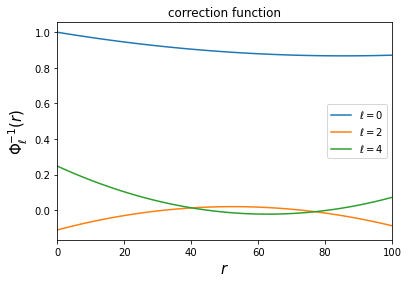

In [230]:
#corr_func = np.loadtxt(results_dir+'correction_function_hipster_R{:04d}_lmax{}.txt'.format(R0,l_max))
#corr_func = np.loadtxt(results_dir+'correction_function_sub_{}_R0{}_lmax{}.txt'.format(N,R0,l_max))

results_dir='/global/homes/r/rmvd2/HIPSTER/output/'
corr_func = np.loadtxt(results_dir+'correction_function_all_pix_R0{}_lmax{}.txt'.format(r_max,0))


def inv_phi_ell_model(r,*par):
    """Reconstruction function from parameters"""
    return par[0]+par[1]*r+par[2]*r**2.
all_ell = np.arange(0,4+2,2)
C_r = lambda r: inv_phi_ell_model(r,*corr_func.T)

rs = np.arange(r_max+1)
for li in range(3):
    plt.plot(rs,[C_r(r)[li]/C_r(0)[0] for r in rs],label=r'$\ell = %d$'%(li*2))
plt.xlabel(r'$r$',fontsize=15)
plt.ylabel(r'$\Phi^{-1}_\ell(r)$',fontsize=15)
plt.legend();
plt.xlim([0,max(rs)]);
#plt.ylim(-2,5)
plt.title('correction function')
plt.show()

### subsampling

In [82]:
sub_galaxies = False

N=2000

if sub_galaxies:
    infile_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_galaxy_degree.txt'
    outfile_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_galaxy_N{}_skewers.txt.sub'.format(N)
else:
    infile_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_degree.txt'
    outfile_name = '/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_N{}_skewers.txt.sub'.format(N)

print(outfile_name)

/pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_N2000_skewers.txt.sub


In [83]:

# First count number of lines
print('Counting particles in file')
with open(infile_name) as f:
    for i, l in enumerate(f):
        pass
total_lines = i + 1
print('Found %s lines in this file' %total_lines)


Counting particles in file
Found 34318369 lines in this file


In [84]:
X,Y,Z,W,T=[np.zeros(total_lines) for _ in range(5)]

In [85]:

print("Reading in data %s"%infile_name);
for n, line in enumerate(open(infile_name, 'r')):
    if n%10000000==0:
        print("Reading line %d of %d" %(n,total_lines))
    split_line=np.array(line.split(" "), dtype=float)
    X[n]=split_line[0];
    Y[n]=split_line[1];
    Z[n]=split_line[2];
    W[n]=split_line[3];
    T[n]=split_line[4]; # target ID of each skewer


Reading in data /pscratch/sd/r/rmvd2/eBOSS_DR16/lya/lya_pixel_weighted_random_degree.txt
Reading line 0 of 34318369
Reading line 10000000 of 34318369
Reading line 20000000 of 34318369
Reading line 30000000 of 34318369


In [86]:
indexes = np.unique(T, return_index=True)[1]
unique_TID = np.array([T[index] for index in sorted(indexes)])

# define numpy random seed for reproducibility
# rmvd2
np.random.seed(10)
random_indices=np.random.choice(unique_TID,N,replace=False)


In [87]:
T

array([3.51406046e+08, 3.51406046e+08, 3.51406046e+08, ...,
       2.00294227e+08, 2.00294227e+08, 2.00294227e+08])

In [88]:
unique_TID

array([3.51406046e+08, 3.52630586e+08, 3.55712094e+08, ...,
       1.99909099e+08, 2.00293983e+08, 2.00294227e+08])

In [89]:
random_indices

array([4.20153890e+07, 5.27224307e+08, 2.99721437e+08, ...,
       5.03066905e+08, 4.42450553e+08, 4.76579138e+08])

In [69]:
random_indices

array([4.20153890e+07, 5.27224307e+08, 2.99721437e+08, ...,
       4.70422900e+08, 4.20828837e+08, 1.55527672e+08])

In [90]:
mask_subsample=np.in1d(T,random_indices)


In [91]:

X = X[mask_subsample]
Y = Y[mask_subsample]
Z = Z[mask_subsample]
W = W[mask_subsample]
T = T[mask_subsample]


In [92]:
count=0 # number of particles chosen so far
perc_count=0 # percentage completion counter

# Now read in correct particles and save to a file

with open(outfile_name,"w") as outfile:
    for p in range(X.size):
        outfile.write("%.8f %.8f %.8f %.8f %.8f\n" %(X[p],Y[p],Z[p],W[p],T[p]))

print("Output positions (of length %d) written succesfully!"%X.size)


Output positions (of length 326411) written succesfully!
